In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

from missingpy import MissForest

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [50]:
df = pd.read_csv('./data/galaxy.csv')
df_cleaned = pd.read_csv('./data/galaxy-cleaned.csv', index_col=0)
df_cleaned_scaled = pd.read_csv('./data/galaxy-cleaned-scaled.csv', index_col=0)

# 만족스럽지 못한 성능!
- 각 model에 대한 '싯가' 관련 feature engineering을 추가하면 어떨까?
    - 각 model에 대한 싯가 분포를 구하고, startprice 관측값이 해당 분포에서 확률이 어떻게 되는지 알 수 있을까?

In [90]:
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1


In [91]:
df[df['BuyItNow']==1].sold.mean()

0.760119940029985

In [92]:
df[df['BuyItNow']==0].sold.mean()

0.21882640586797067

In [95]:
df.groupby('productline')['startprice'].mean().sort_values(ascending=False)

productline
Galaxy_Note10    366.931311
Galaxy_S10       294.583750
Galaxy_Note9     254.561402
Galaxy_S9        231.268101
Galaxy_Note8     176.065033
Unknown          171.994265
Galaxy_S8        165.883321
Galaxy_S7         84.190000
Name: startprice, dtype: float64

In [96]:
df.groupby('productline')['sold'].mean().sort_values(ascending=False)

productline
Galaxy_S7        0.550661
Galaxy_Note8     0.522876
Galaxy_S10       0.500000
Galaxy_S8        0.476534
Galaxy_Note9     0.457944
Galaxy_Note10    0.424501
Galaxy_S9        0.411392
Unknown          0.401961
Name: sold, dtype: float64

In [68]:
X = df_cleaned.drop('sold', axis=1)
y = df_cleaned['sold']

In [69]:
X0 = df.drop('sold', axis=1)
y0 = df['sold']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=11)
#X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

# modeling

In [18]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# y = np.array([1, 1, 1, 2, 2, 2])

eclf1 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                         voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
eclf1_pred = eclf1.predict(X_test)

np.array_equal(eclf1.named_estimators_.lr.predict(X_test),
                eclf1.named_estimators_['lr'].predict(X_test))

eclf2 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
         voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
eclf2_pred = eclf2.predict(X_test)


eclf3 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft', weights=[2,1,1],
        flatten_transform=True)
eclf3 = eclf3.fit(X_train, y_train)
eclf3_pred = eclf3.predict(X_test)
print(eclf3.transform(X_test).shape)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

(297, 6)


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [19]:
accuracy_score(y_test, eclf1_pred), accuracy_score(y_test, eclf2_pred), accuracy_score(y_test, eclf3_pred)

(0.7811447811447811, 0.7845117845117845, 0.7744107744107744)

In [88]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# y = np.array([1, 1, 1, 2, 2, 2])

eclf1 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                         voting='hard')
eclf1 = eclf1.fit(X2_train, y2_train)
eclf1_pred = eclf1.predict(X2_test)

np.array_equal(eclf1.named_estimators_.lr.predict(X2_test),
                eclf1.named_estimators_['lr'].predict(X2_test))

eclf2 = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
         voting='soft')
eclf2 = eclf2.fit(X2_train, y2_train)
eclf2_pred = eclf2.predict(X2_test)


eclf3 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft', weights=[2,1,1],
        flatten_transform=True)
eclf3 = eclf3.fit(X2_train, y2_train)
eclf3_pred = eclf3.predict(X2_test)
print(eclf3.transform(X2_test).shape)

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

(297, 6)


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [89]:
accuracy_score(y_test, eclf1_pred), accuracy_score(y_test, eclf2_pred), accuracy_score(y_test, eclf3_pred)

(0.7946127946127947, 0.7811447811447811, 0.797979797979798)

In [20]:
params = {
    'n_estimators':[50, 100, 150],
    'criterion':['gini', 'entropy'],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=0,
                                     

In [21]:
pred = grid_cv.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.7912457912457912

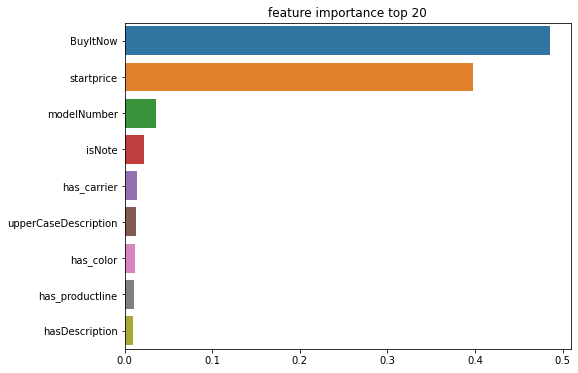

In [22]:
ftr_importances_values = grid_cv.best_estimator_.feature_importances_
ftr_importances_values = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances_values.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('feature importance top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [23]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_accuracy

0.8013468013468014

In [44]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_accuracy

[16:21:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7744107744107744

# MissForest

In [71]:
y2 = y0.copy()
X2 = df.loc[:, :"upperCaseDescription"]
#X = X.drop(['carrier', 'color'], axis=1) - 드롭하지 않음
X2 = pd.concat([X2, pd.get_dummies(X2['productline'], prefix='productline')], axis=1)
X2 = X2.drop('productline', axis=1)
X2['noDescription'] = X2['noDescription'].apply(lambda x: 1 if x == 'contains description' else 0)

X2_with_label = pd.concat([X2, y2], axis=1)

X2_with_label['BuyItNow'] = X2_with_label['BuyItNow'].astype('category')
X2_with_label['sold'] = X2_with_label['sold'].astype('category')
X2_with_label['carrier'] = X2_with_label['carrier'].map({'None':str(0),
                             'AT&T':str(1),
                             'Verizon':str(2),
                             'Sprint/T-Mobile':str(3)})
X2_with_label['color'] = X2_with_label['color'].map({'White':str(0),
                             'Midnight Black':str(1),
                             'Space Gray':str(2),
                             'Gold':str(3),
                             'Black':str(4),
                            'Aura Black':str(5),
                            'Prism Black':str(6)
                            })

X2_with_label['carrier'] = X2_with_label['carrier'].astype('category')
X2_with_label['color'] = X2_with_label['color'].astype('category')

In [73]:
imp = MissForest(max_iter=5)
X_ = X2_with_label[['BuyItNow', 'startprice', 'carrier', 'color', 'sold']]
X_ = imp.fit_transform(X_)
X_

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


array([[0.00000000e+00, 1.99990000e+02, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [0.00000000e+00, 2.35000000e+02, 0.00000000e+00, 8.65333333e-01,
        0.00000000e+00],
       [0.00000000e+00, 1.99990000e+02, 1.30000000e-01, 1.51647475e+00,
        0.00000000e+00],
       ...,
       [0.00000000e+00, 3.29990000e+02, 0.00000000e+00, 2.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 8.90000000e+01, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [0.00000000e+00, 1.19990000e+02, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00]])

In [75]:
imp2 = MissForest(max_iter=5)
X2_ = X2_with_label
X2_ = imp.fit_transform(X2_)
X2_

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


array([[  0.  , 199.99,   0.  , ...,   1.  ,   0.  ,   1.  ],
       [  0.  , 235.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  , 199.99,   0.63, ...,   0.  ,   1.  ,   0.  ],
       ...,
       [  0.  , 329.99,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,  89.  ,   0.  , ...,   0.  ,   0.  ,   1.  ],
       [  0.  , 119.99,   1.  , ...,   0.  ,   0.  ,   0.  ]])

In [76]:
mf_X = pd.DataFrame(X_, columns=['BuyItNow', 'startprice', 'carrier', 'color', 'sold'])

X2_with_label['carrier'] = mf_X['carrier'].apply(lambda x: round(x))
X2_with_label['color'] = mf_X['color'].apply(lambda x: round(x))

X2_with_label = pd.concat([X2_with_label,
                           pd.get_dummies(X2_with_label['carrier'],
                                         prefix='carrier')], axis=1)

X2_with_label = pd.concat([X2_with_label,
                           pd.get_dummies(X2_with_label['color'],
                                         prefix='color')], axis=1)

X2_with_label = X2_with_label.drop(['carrier', 'color'], axis=1)

In [78]:
y2 = X2_with_label['sold']
X2 = X2_with_label.drop('sold', axis=1)

In [79]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

# modeling with mf dataset

In [80]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[50, 100, 150],
    'criterion':['gini', 'entropy'],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X2_train, y2_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=0,
                                     

In [81]:
pred = grid_cv.best_estimator_.predict(X2_test)
accuracy = accuracy_score(y2_test, pred)
accuracy

0.7744107744107744

In [83]:
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X2_train, y2_train)
gb_pred = gb_clf.predict(X2_test)
gb_accuracy = accuracy_score(y2_test, gb_pred)
gb_accuracy

0.8013468013468014

# Error Analysis